In [1]:
%load_ext autoreload
%autoreload 2
from agent_configs import make_agent
from training import run_training, train_reps, train_or_load_condition
from eval_funcs import avg_stats, eval_holdout_stats, eval_total_cert_stats

def gauss(data, filters=[(0,100,1.0)]):
    from scipy.ndimage.filters import gaussian_filter1d
    for (st, en, sig) in filters:
        if(sig == 0): continue
        l = len(data) 
        en = max(en,l) if en != -1 else en
        if(l > st):
            data[st:en] = gaussian_filter1d(data[st:en],sigma=sig)
    return data

CRE Cache Lives Here:  /home/danny/.cache/cre/cre_cache


/home/danny/.local/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


unicode_type


In [6]:
mc_conditions = {
    ("mc", "decision_tree", False) : {"n_prob": 100, "reps" : 40},
    ("mc", "random_forest", False) : {"n_prob": 100, "reps" : 20},
    ("mc", "xg_boost", False) : {"n_prob": 100, "reps" : 20},
    ("mc", "stand", False) : {"n_prob": 100, "reps" : 40},
    #("mc", "stand-relaxed", False) : {"n_prob": 100, "reps" : 6},
    #("mc", "stand", True) : {"n_prob": 100, "reps" : 1},
}

frac_conditions = {
    ("frac", "decision_tree", False) : {"n_prob": 100, "reps" : 40},
    ("frac", "random_forest", False) : {"n_prob": 100, "reps" : 6},
    ("frac", "stand", False) : {"n_prob": 100, "reps" : 20},
}

stat_cache = {}
def stats_by_cond(conditions, grp, stat_name, kind="avg"):
    out = {}
    for tup, kwargs in conditions.items():
        if(tup not in stat_cache):
            ret = train_or_load_condition(*tup, 
                    n_prob=kwargs.get("n_probs", 100), reps=kwargs.get("reps", 3))
            stat_cache[tup] = ret
            
        ret = stat_cache[tup]
        out[(tup[1], tup[2])] = ret[grp][stat_name][kind]
    return out

def stats_at_index_by_cond(conditions, grp, stat_name, index, kind="avg"):
    stats = stats_by_cond(conditions, grp, stat_name, kind)
    stats = {k:v[index] for k,v in stats.items()}
    return stats
    

def print_stat(name, val, prec=2):
    print(f"{name}: {val*100:.{prec}f}%")

def print_stats(conditions, grp, name, title=None, big_better=True, index=None):
    title = title if title else name
    if(index is None):
        d = stats_by_cond(conditions, grp, name)
    else:
        d = stats_at_index_by_cond(conditions, grp, name, index=index)
    print(f"{title}:")
    best_ind = np.argmax([d if big_better else -d for d in d.values()])
    for i, (cond, val) in enumerate(d.items()):
        when, proc = cond
        bold = best_ind == i
        pre = "\033[1m" if bold else ""
        post = "\033[0m" if bold else ""
        ps = "-proc" if proc else ""
        print(f"  {when}{ps}: {pre}{val*100:.2f}%{post}")

        


['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


/tmp/ipykernel_47105/2809534444.py:8: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


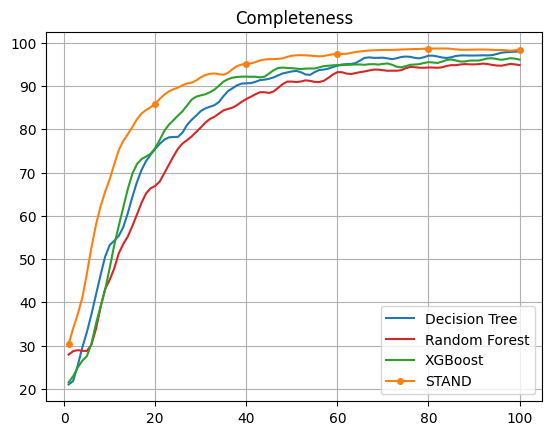

In [7]:
        
import matplotlib.pyplot as plt
import numpy as np

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

cond_colors = {
    "decision_tree" : colors[0],
    "random_forest" : colors[3],
    "xg_boost" : colors[2],
    "stand" : colors[1], # Orange
}

cond_labels = {
    "decision_tree" : "Decision Tree",
    "random_forest" : "Random Forest",
    "xg_boost" : "XGBoost",
    "stand" : "STAND",
}

cond_marker_props = {
    "stand" : {"marker" : ".", "markersize" : 8, "markevery" : [0,19,39,59,79, -1]}
}

def plot_stat(conditions, stat, grp=1, title=None):
    title = title if title else stat
    for cond, curve in stats_by_cond(conditions, grp, stat).items():
        when, has_proc = cond 
        plt.plot(np.arange(1,len(curve)+1), gauss(curve*100), color=cond_colors.get(when, "grey"), 
                 label=cond_labels.get(when, when), **cond_marker_props.get(when, {}))
    plt.grid()
    plt.title(title)
    plt.legend()    
    plt.show()
    

plot_stat(mc_conditions, "completeness", 0, "Completeness")    

## MC Addition Total Stats

In [58]:
print_stats(mc_conditions, 0, "completeness", "Completeness prob=20", True, index=19)
print_stats(mc_conditions, 0, "completeness", "Completeness prob=50", True, index=49)
print_stats(mc_conditions, 0, "completeness", "Completeness prob=100", True, index=99)
print()
print_stats(mc_conditions, 1, "total_prod_monot", "Total Productive Monotonicity")
print_stats(mc_conditions, 1, "total_error_reocc", "Total Error Reoccurance", False)
print_stats(mc_conditions, 1, "total_FN_reocc", "Total Comission Reoccurance", False)
print_stats(mc_conditions, 1, "total_FP_reocc", "Total Omission Reoccurance", False)
print()
print_stats(mc_conditions, 1, ("total_precision",.9), "Total Precision @90%", True)
print_stats(mc_conditions, 1, ("total_precision",1.0), "Total Precision @100%", True)

Completeness prob=20:
  decision_tree: 75.53%
  random_forest: 66.66%
  xg_boost: 75.78%
  stand: 85.56%
Completeness prob=50:
  decision_tree: 93.21%
  random_forest: 90.78%
  xg_boost: 94.25%
  stand: 97.06%
Completeness prob=100:
  decision_tree: 97.98%
  random_forest: 94.73%
  xg_boost: 95.87%
  stand: 98.54%

Total Productive Monotonicity:
  decision_tree: 55.14%
  random_forest: 51.40%
  xg_boost: 52.92%
  stand: 70.45%
Total Error Reoccurance:
  decision_tree: 0.38%
  random_forest: 1.13%
  xg_boost: 0.76%
  stand: 0.55%
Total Comission Reoccurance:
  decision_tree: 1.36%
  random_forest: 1.13%
  xg_boost: 0.79%
  stand: 0.56%
Total Omission Reoccurance:
  decision_tree: 0.00%
  random_forest: 1.13%
  xg_boost: 0.75%
  stand: 0.54%

Total Precision @90%:
  decision_tree: 86.60%
  random_forest: 97.39%
  xg_boost: 98.02%
  stand: 95.81%
Total Precision @100%:
  decision_tree: 86.60%
  random_forest: 95.48%
  xg_boost: 100.00%
  stand: 99.77%


## Fractions Total Stats

In [59]:
print_stats(frac_conditions, 0, "completeness", "Completeness prob=20", True, index=19)
print_stats(frac_conditions, 0, "completeness", "Completeness prob=50", True, index=49)
print_stats(frac_conditions, 0, "completeness", "Completeness prob=100", True, index=99)
print()
print_stats(frac_conditions, 1, "total_prod_monot", "Total Productive Monotonicity")
print_stats(frac_conditions, 1, "total_error_reocc", "Total Error Reoccurance", False)
print_stats(frac_conditions, 1, "total_FN_reocc", "Total Comission Reoccurance", False)
print_stats(frac_conditions, 1, "total_FP_reocc", "Total Omission Reoccurance", False)
print()
print_stats(frac_conditions, 1, ("total_precision",.9), "Total Precision @90%", True)
print_stats(frac_conditions, 1, ("total_precision",1.0), "Total Precision @100%", True)

Completeness prob=20:
  decision_tree: 82.20%
  random_forest: 69.58%
  stand: 84.57%
Completeness prob=50:
  decision_tree: 88.83%
  random_forest: 85.22%
  stand: 90.09%
Completeness prob=100:
  decision_tree: 90.93%
  random_forest: 88.43%
  stand: 94.58%

Total Productive Monotonicity:
  decision_tree: 58.19%
  random_forest: 50.57%
  stand: 80.02%
Total Error Reoccurance:
  decision_tree: 0.20%
  random_forest: 0.87%
  stand: 0.50%
Total Comission Reoccurance:
  decision_tree: 0.73%
  random_forest: 0.68%
  stand: 0.47%
Total Omission Reoccurance:
  decision_tree: 0.00%
  random_forest: 0.92%
  stand: 0.51%

Total Precision @90%:
  decision_tree: 88.02%
  random_forest: 92.47%
  stand: 93.20%
Total Precision @100%:
  decision_tree: 88.02%
  random_forest: 91.83%
  stand: 98.49%


/tmp/ipykernel_47105/2809534444.py:8: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


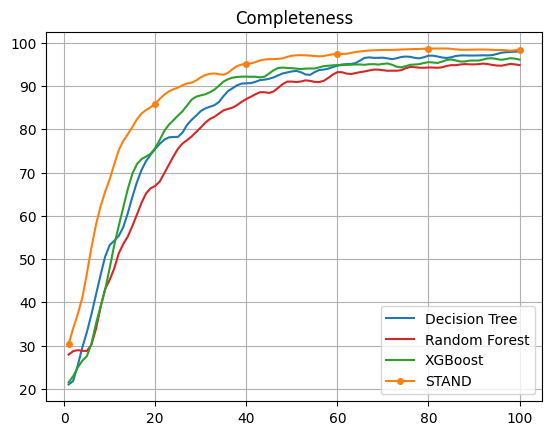

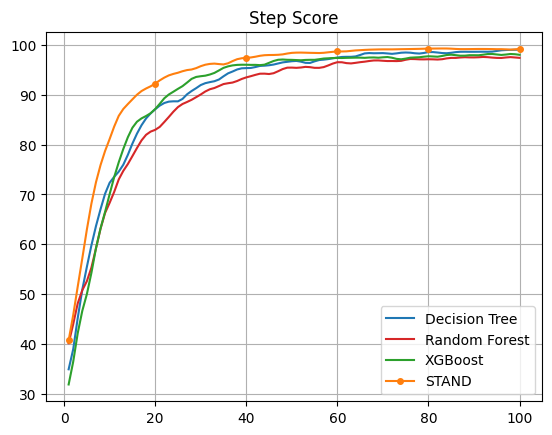

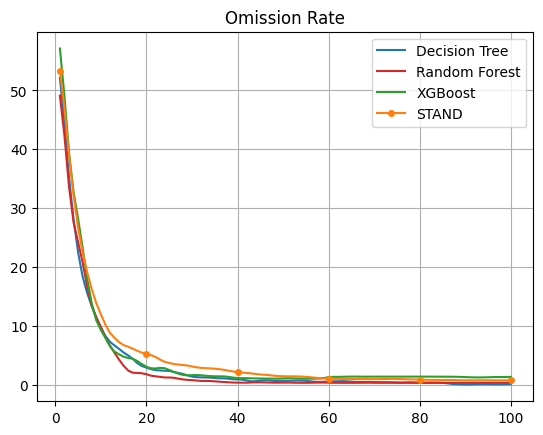

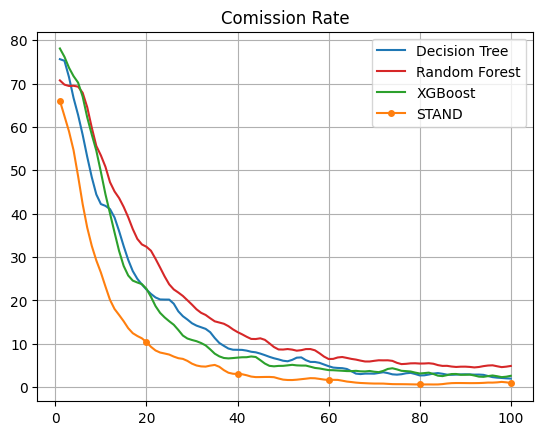

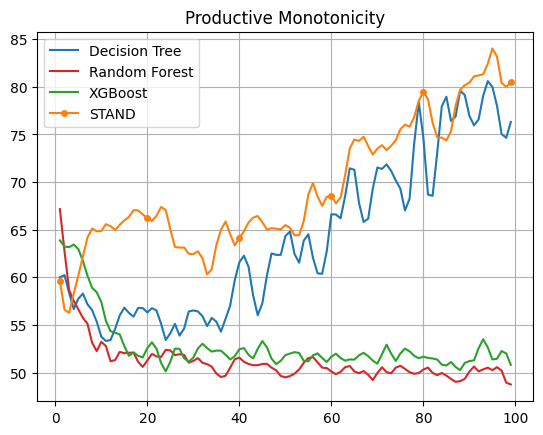

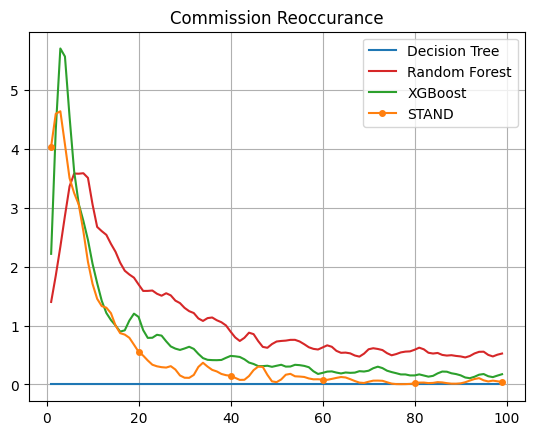

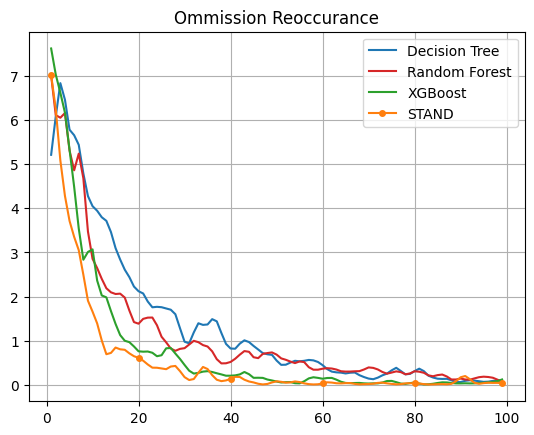

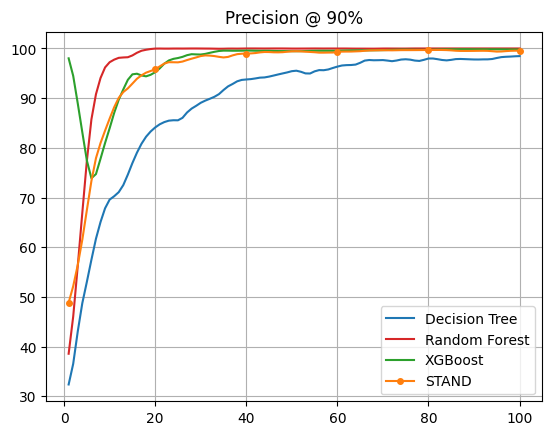

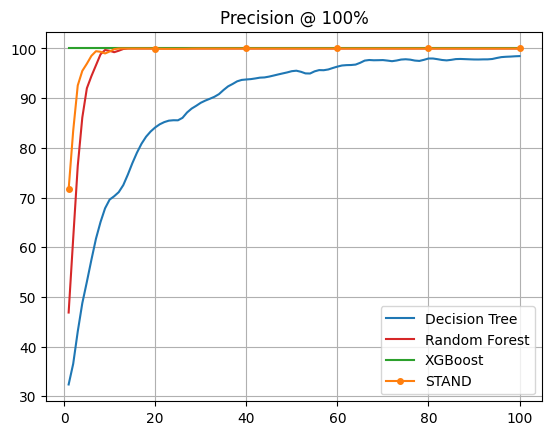

In [9]:
plot_stat(mc_conditions, "completeness", 0, "Completeness")
plot_stat(mc_conditions, "step_score", 0, "Step Score")
plot_stat(mc_conditions, "omission_rate", 0, "Omission Rate")
plot_stat(mc_conditions, "comission_rate", 0, "Comission Rate")

plot_stat(mc_conditions, "prod_monot", 1, "Productive Monotonicity")
plot_stat(mc_conditions, "FP_reocc", 1, "Commission Reoccurance")
plot_stat(mc_conditions, "FN_reocc", 1, "Ommission Reoccurance")
plot_stat(mc_conditions, ('precision', .9), 1, "Precision @ 90%")
plot_stat(mc_conditions, ('precision', 1.0), 1, "Precision @ 100%")



/tmp/ipykernel_47105/2809534444.py:8: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


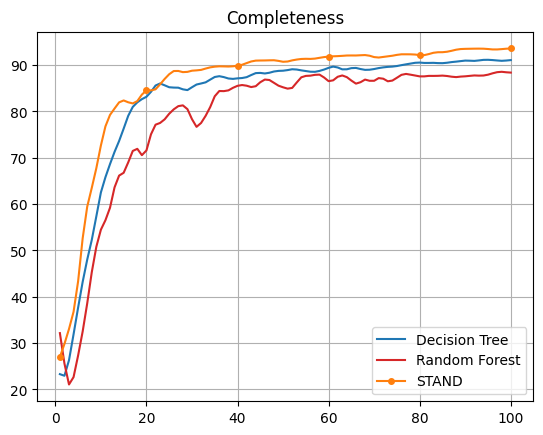

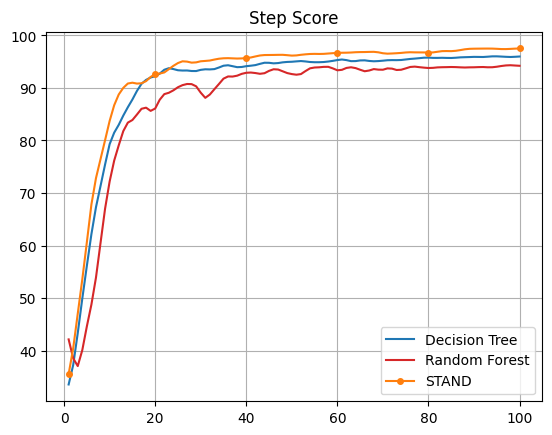

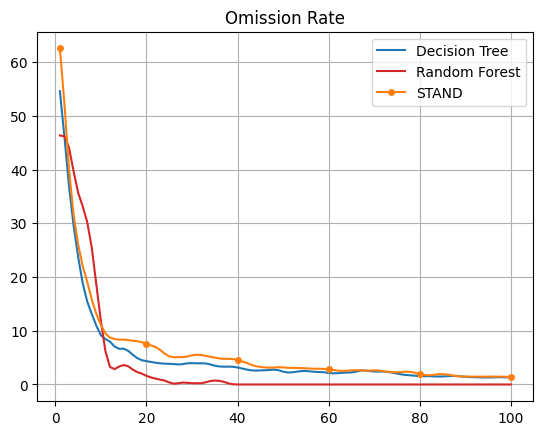

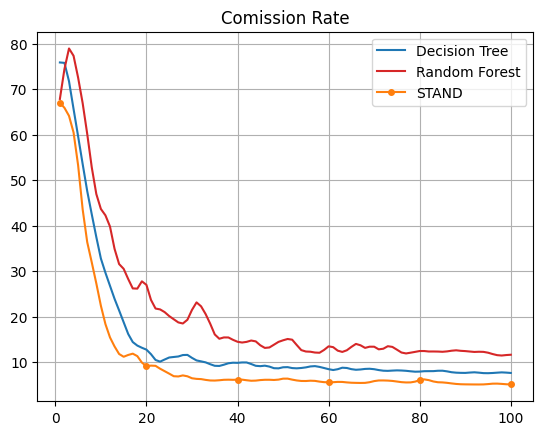

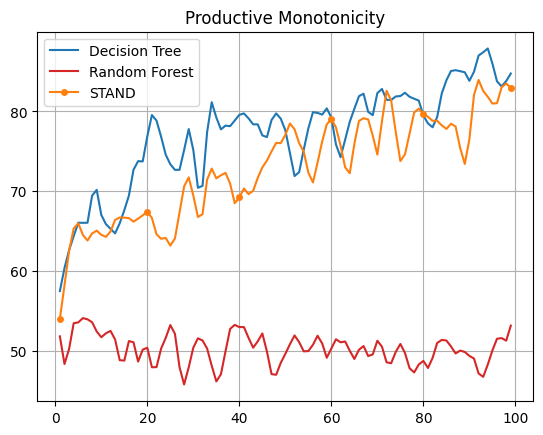

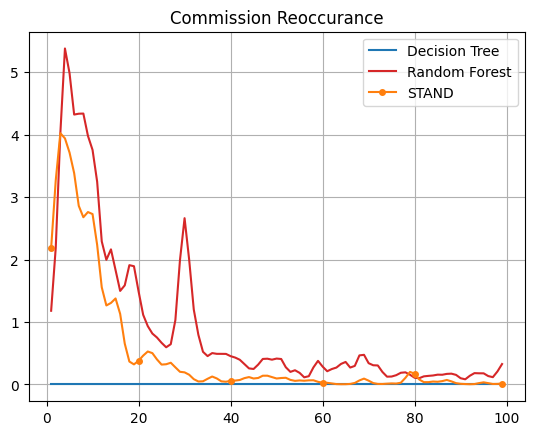

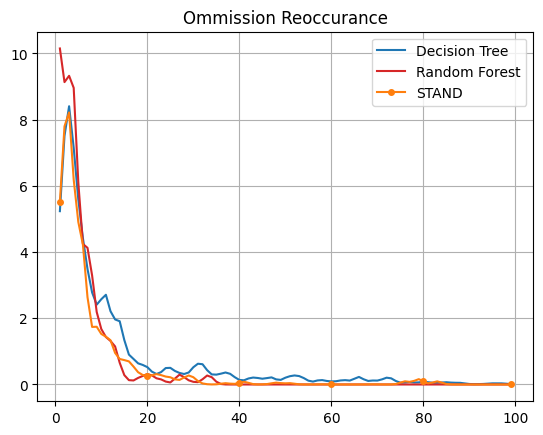

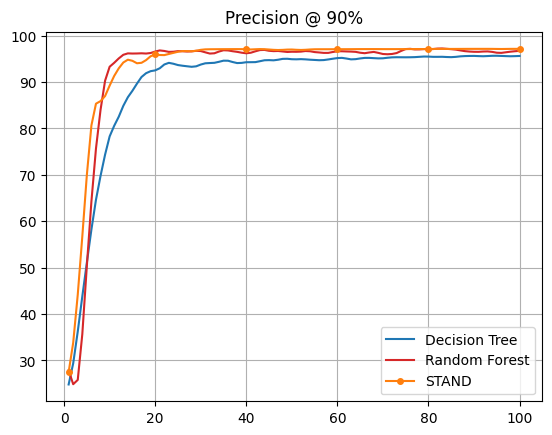

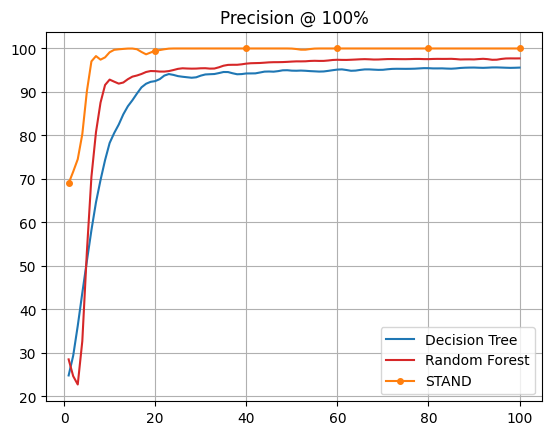

In [10]:
plot_stat(frac_conditions, "completeness", 0, "Completeness")
plot_stat(frac_conditions, "step_score", 0, "Step Score")
plot_stat(frac_conditions, "omission_rate", 0, "Omission Rate")
plot_stat(frac_conditions, "comission_rate", 0, "Comission Rate")

plot_stat(frac_conditions, "prod_monot", 1, "Productive Monotonicity")
plot_stat(frac_conditions, "FP_reocc", 1, "Commission Reoccurance")
plot_stat(frac_conditions, "FN_reocc", 1, "Ommission Reoccurance")
plot_stat(frac_conditions, ('precision', .9), 1, "Precision @ 90%")
plot_stat(frac_conditions, ('precision', 1.0), 1, "Precision @ 100%")


## Fit Time

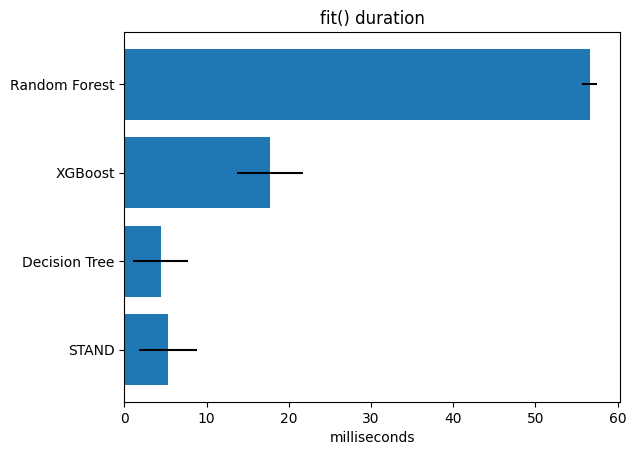

In [99]:
fit_times = {
    "stand" :         {"avg" : 5.3,   "std" : 3.539},
    "decision_tree" : {"avg" : 4.424, "std" : 3.327},
    "xg_boost" :      {"avg" : 17.735, "std" : 3.974},
    "random_forest" : {"avg" : 56.588, "std" : 0.876},
    
}

fig, ax = plt.subplots()

y_pos = np.arange(len(fit_times))
avgs = [v['avg'] for v in fit_times.values()]
stds = [v['std'] for v in fit_times.values()]

ax.barh(y_pos, avgs, xerr=stds, align='center')
ax.set_yticks(y_pos, labels=[cond_labels[k] for k in fit_times])
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('milliseconds')
ax.set_title('fit() duration')

plt.show()

## Predict Time

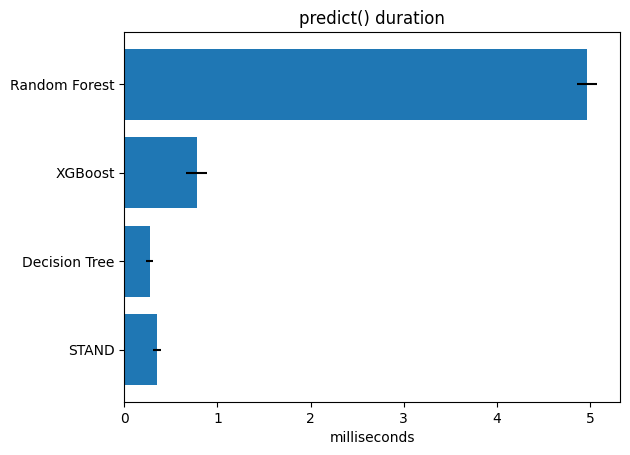

In [100]:
predict_times = {
    "stand" :         {"avg" : 0.355, "std" : 0.043},
    "decision_tree" : {"avg" : 0.273, "std" : 0.038},
    "xg_boost" :      {"avg" : 0.775, "std" : 0.112},
    "random_forest" : {"avg" : 4.969, "std" : 0.104},
    
}

fig, ax = plt.subplots()

y_pos = np.arange(len(predict_times))
avgs = [v['avg'] for v in predict_times.values()]
stds = [v['std'] for v in predict_times.values()]

ax.barh(y_pos, avgs, xerr=stds, align='center')
ax.set_yticks(y_pos, labels=[cond_labels[k] for k in predict_times])
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('milliseconds')
ax.set_title('predict() duration')

plt.show()

In [82]:
def py_setitem(size):
    l = [0]*size
    for i in range(size):
        l[i] = i
    return l

def np_setitem(size):
    l = np.zeros(size)
    for i in range(size):
        l[i] = i
    return l

def py_getitem(size):
    l = [0]*size
    s = 0
    for i in range(size):
        s = l[i]
    return s
        
def np_getitem(size):
    l = np.zeros(size)
    s = 0
    for i in range(size):
        s = l[i]
    return s 
%timeit py_setitem(100000)
%timeit np_setitem(100000)
%timeit py_getitem(100000)
%timeit np_getitem(100000)

2.31 ms ± 95.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.05 ms ± 99.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.36 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.18 ms ± 57.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [112]:
from numba import njit, types, i8
from numba.typed import List
from numba.types import ListType

@njit(types.void(ListType(i8), i8))
def append_it(lst, other):
    lst.append(other)

append_it_ep = append_it.overloads[(ListType(i8), i8)].entry_point

def nb_append(size):
    l = List()
    for i in range(size):
        l.append(i)
    return l

def nb_append_custom(size):
    l = List.empty_list(i8)
    for i in range(size):
        append_it(l, i)
    return l

def nb_append_custom_ep(size):
    l = List.empty_list(i8)
    for i in range(size):
        append_it_ep(l, i)
    return l

def py_append(size):
    l = []
    for i in range(size):
        l.append(i)
    return l

%timeit py_append(100000)
%timeit nb_append(100000)
%timeit nb_append_custom(100000)
%timeit nb_append_custom_ep(100000)


4.1 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
111 ms ± 4.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
103 ms ± 8.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
40.9 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<function __main__._Closure.append_it>

In [ ]:
from training import train_or_load_rep
stats, _, _  = train_or_load_rep("mc", "stand", False, 100, 0)
print(stats['completeness'][-1])
